## Diabetes Prediction

In this file we'll take a look at a diabetes data set and see if we can make a good classification model to see if indivuals have diabetes, is pre- diabetic, or neither. We will use k-nearest neighbors (KNN) classification algorithm.

In [11]:
library(tidyverse)
library(janitor)
library(tidymodels)
library(kknn)

In [12]:
data <- read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
glimpse(data)

Rows: 253680 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 253,680
Columns: 22
$ Diabetes_012         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0…
$ HighBP               <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1…
$ HighChol             <dbl> 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1…
$ CholCheck            <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ BMI                  <dbl> 40, 25, 28, 27, 24, 25, 30, 25, 30, 24, 25, 34, 2…
$ Smoker               <dbl> 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0…
$ Stroke               <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0…
$ HeartDiseaseorAttack <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ PhysActivity         <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1…
$ Fruits               <dbl> 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1…
$ Veggies              <dbl> 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1…
$ HvyAlcoholConsump    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AnyHealthcar

First we will clean the column names:

In [106]:
set.seed(1212)
diabetes_data <- data |> 
clean_names() |> 
mutate(diabetes_012 = as_factor(diabetes_012)) |> 
slice_sample(n=10000) |> 
glimpse()

Rows: 10,000
Columns: 22
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,…
$ high_bp                <dbl> 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,…
$ high_chol              <dbl> 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,…
$ chol_check             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ bmi                    <dbl> 30, 33, 27, 21, 41, 20, 26, 32, 20, 29, 22, 29,…
$ smoker                 <dbl> 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,…
$ stroke                 <dbl> 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,…
$ phys_activity          <dbl> 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,…
$ fruits                 <dbl> 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,…
$ veggies                <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,…
$ hvy_alcohol_consump    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcar

I will use `age`, `phys_activity`, `bmi`, `high_chol` as my predictors

Here we will do the inital split where we split the data into the training set and testing set

In [107]:
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = diabetes_012)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

First we will have to find the value of $K$. Here we will make the recipe and specification for the model

In [108]:
diabetes_recipe <- recipe(diabetes_012 ~ age + phys_activity + bmi + high_chol,
                        data = diabetes_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [109]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

We will be using 5 fold cross validation

In [110]:
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = diabetes_012)

We will make a tibble of $K$ values from 1 to 100 increasing by 5, then we will put everything into a workflow.

In [111]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(diabetes_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")


We can make a plot of a accuracy vs the k values and pick the largest k value that has the highest
value for $K$.

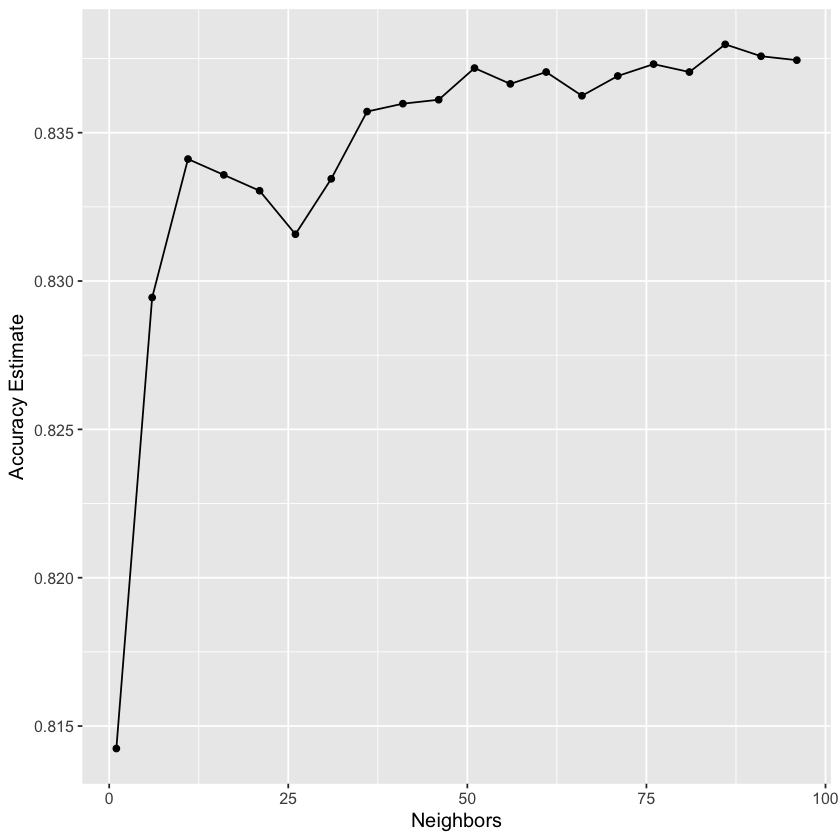

In [112]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [113]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 86

Now that we have a value for $K$, we can make the recipe, specification, and workflow
with new $K$ value in mind.

In [114]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(diabetes_recipe) |>
  add_model(knn_spec) |>
  fit(data = diabetes_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(86,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1609548
Best kernel: rectangular
Best k: 86

Finally, we can predict the model. 

In [115]:
diabetes_test_predictions <- predict(knn_fit, diabetes_test) |>
  bind_cols(diabetes_test)

diabetes_test_predictions |>
  metrics(truth = diabetes_012, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8416633


In [116]:
diabetes_test_predictions |> pull(diabetes_012) |> levels()

[1] "0" "1" "2"

In [117]:
diabetes_test_predictions |>
    precision(truth = diabetes_012, estimate = .pred_class, event_level="third")

Warning message:
“While computing multiclass `precision()`, some levels had no predicted events
(i.e. `true_positive + false_positive = 0`).
Precision is undefined in this case, and those levels will be removed from the
averaged result.
Note that the following number of true events actually occurred for each
problematic event level:
'1': 33”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.6733266


In [118]:
diabetes_test_predictions |>
    recall(truth = diabetes_012, estimate = .pred_class, event_level="third")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.3471236


Here it can be seen that the the model has an accuracy of 84%. With more folds and a deeper insepction of the predictors this moddel can be approved with higher accuracy.